In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lifetimes
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
import seaborn as sns


In [2]:
df = pd.read_parquet("transactional_dataset_train.parquet")
df.head()

,account_id,event_time,amount
0,132285932,2021-08-14 21:18:04.956,19.99
1,131792942,2021-08-14 21:28:33.266,9.99
2,180084640,2021-08-14 19:10:59.833,0.99
3,132486244,2021-08-14 20:35:14.897,9.99
4,131970262,2021-08-14 19:30:59.234,0.99


In [3]:
summary = lifetimes.utils.summary_data_from_transaction_data(df,"account_id","event_time","amount",freq='s',freq_multiplier=86400)
summary = summary.reset_index()
summary.sort_values(by="frequency",ascending = False)

,account_id,frequency,recency,T,monetary_value
67223,98491143,103.0,2.189190,176.550914,26.718155
50591,167529481,96.0,2.891840,60.774086,12.594167
10480,113958422,88.0,1.664942,86.127986,30.058182
52280,169616730,82.0,2.894387,50.590313,34.770488
19734,123433842,80.0,2.371910,43.490475,9.152500
...,...,...,...,...,...
29364,129610414,0.0,0.000000,16.880255,0.000000
29366,129610564,0.0,0.000000,16.507118,0.000000
29370,129611652,0.0,0.000000,15.681123,0.000000
29375,129612734,0.0,0.000000,16.873623,0.000000


count    69858.000000
mean         1.304604
std          2.965060
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        103.000000
Name: frequency, dtype: float64
percentage of one time buyers 57.11


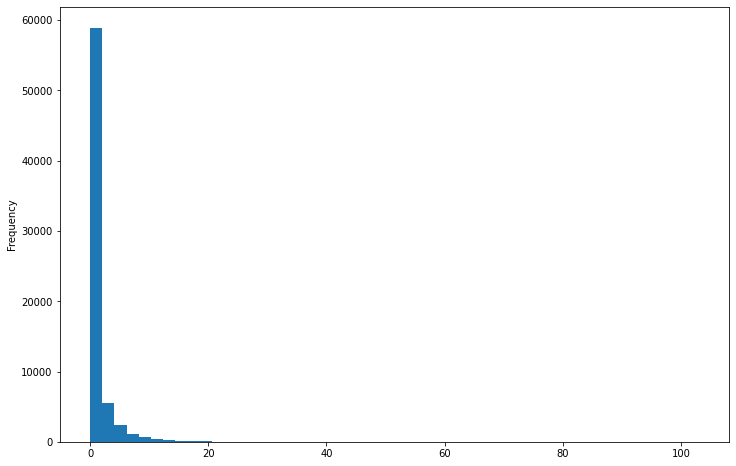

In [4]:
fig = plt.figure(figsize=(12,8))
summary["frequency"].plot(kind="hist",bins = 50)
print(summary["frequency"].describe())
percentage = sum(summary["frequency"]==0)/(len(summary))*(100)
print(f"percentage of one time buyers { round(percentage,2)}")
#základna popisná štatistika summary tabuľlky nášho datasetu plus podiel one time buyerov a jednoduchý histogram na kotorom 
#vidno početnosť zákazníkov, prevládajú hráči čo nákupili 5-krát a menej. s grafmi sa ešte určite pohrám 

In [5]:
par = lifetimes.fitters.pareto_nbd_fitter.ParetoNBDFitter()
par.fit(summary["frequency"],summary["recency"],summary["T"])

<lifetimes.ParetoNBDFitter: fitted with 69858 subjects, alpha: 0.19, beta: 1.49, r: 0.45, s: 2.70>

In [6]:
summary["probability_alive"] = par.conditional_probability_alive(summary["frequency"],summary["recency"],summary["T"])
summary.sort_values(by="probability_alive",ascending = False).head(10)

,account_id,frequency,recency,T,monetary_value,probability_alive
36554,133513494,3.0,0.076725,0.076725,13.323333,1.000000
64380,180987991,3.0,2.932812,3.137315,14.323333,0.873327
36212,133188742,2.0,0.033704,0.095556,4.990000,0.867148
36569,133551363,6.0,2.042292,2.214340,8.323333,0.850351
64327,180936061,2.0,2.704537,3.085093,14.990000,0.763739
36499,133456254,3.0,2.768067,3.137569,1.656667,0.762221
64344,180952230,4.0,1.202164,1.434699,4.240000,0.734072
36582,133578693,2.0,0.780301,1.007708,1.990000,0.721706
64446,181052341,6.0,1.896447,2.187998,8.323333,0.716484
36052,133084422,8.0,2.930775,3.306019,8.365000,0.705330


c:\users\fpolo\appdata\local\programs\python\python39\lib\site-packages\lifetimes\fitters\pareto_nbd_fitter.py:323: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + exp(log(s) - log(r + s + x) + (r + x) * log(alpha + T) + s * log(beta + T) + A_0))


<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

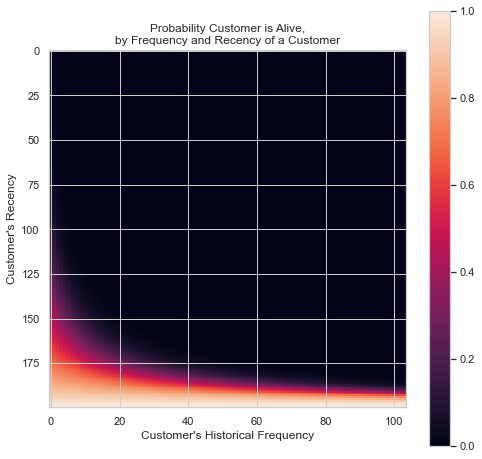

In [7]:
fig = plt.figure(figsize=(8,8))
sns.set_theme(style="whitegrid",palette="colorblind")
plot_probability_alive_matrix(par)

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel='ahoj', ylabel="Customer's Recency">

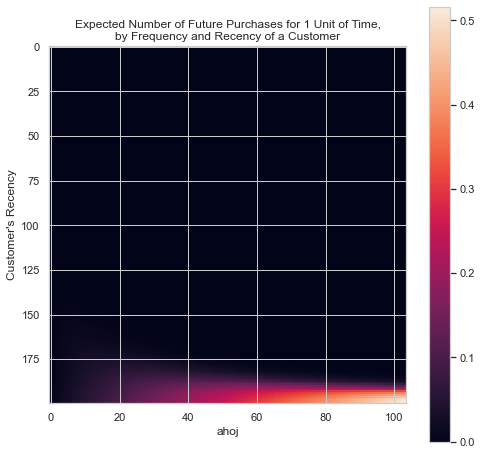

In [8]:
fig = plt.figure(figsize=(8,8))
sns.set_theme(style="whitegrid",palette="colorblind")
plot_frequency_recency_matrix(par,xlabel="ahoj")

In [9]:
t=10 #ešte overím či to berie ako dni ked je celý dataset v dňoch alebo to treba špecifikovať.
summary["predicted_num_of_purchases"]=round(par.conditional_expected_number_of_purchases_up_to_time(180,summary["frequency"],summary["recency"],summary["T"]),2)
summary.sort_values(by="predicted_num_of_purchases",ascending = False).head()
#vytvorenie nového stĺpca za pomoci vstavanej funkcie. táto funkcia predpovedá počet nákupov za určitý čas(prvý argument funkcie)
#pre toto predikovanie používa stĺpce frequency, recency a T(Čas od prvého nákupu)

,account_id,frequency,recency,T,monetary_value,probability_alive,predicted_num_of_purchases
36554,133513494,3.0,0.076725,0.076725,13.323333,1.000000,11.75
64329,180939621,16.0,2.928252,3.307014,8.865000,0.569764,7.56
36212,133188742,2.0,0.033704,0.095556,4.990000,0.867148,6.85
64351,180959270,25.0,1.981435,2.298611,26.710000,0.287402,6.55
36569,133551363,6.0,2.042292,2.214340,8.323333,0.850351,4.97


No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Expected Number of Repeat Purchases per Customer'}, xlabel='Time Since First Purchase'>

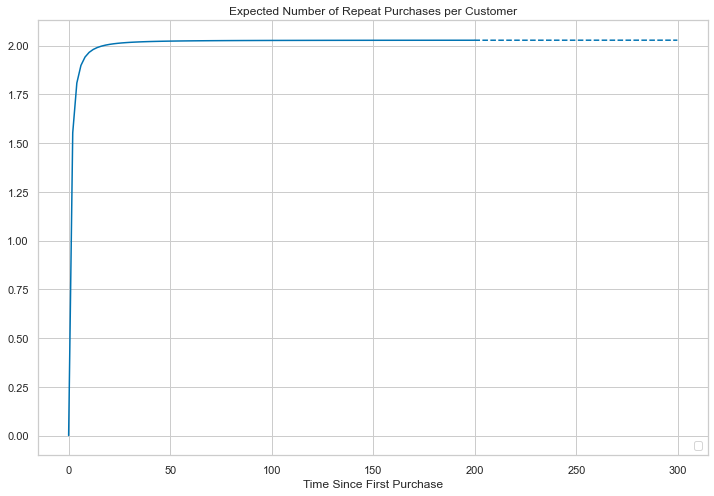

In [18]:
# zaujímavý graf vidíme logaritmický vývoj, vidíme že v prvých dňooch po nákupe možno očakávať vysokú pravdepodobnosť opakovaného nákupu avšak potom už počet očakávaných nákupov takmer nerastie 
fig= plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid",palette="colorblind")
lifetimes.plotting.plot_expected_repeat_purchases(par)

In [11]:
# odfiltrovanie one time buyerov
gamma_summary = summary[summary["frequency"]>0]
gamma_summary.sort_values(by="probability_alive",ascending = False).head(10)

,account_id,frequency,recency,T,monetary_value,probability_alive,predicted_num_of_purchases
36554,133513494,3.0,0.076725,0.076725,13.323333,1.000000,11.75
64380,180987991,3.0,2.932812,3.137315,14.323333,0.873327,2.46
36212,133188742,2.0,0.033704,0.095556,4.990000,0.867148,6.85
36569,133551363,6.0,2.042292,2.214340,8.323333,0.850351,4.97
64327,180936061,2.0,2.704537,3.085093,14.990000,0.763739,1.54
36499,133456254,3.0,2.768067,3.137569,1.656667,0.762221,2.15
64344,180952230,4.0,1.202164,1.434699,4.240000,0.734072,3.46
36582,133578693,2.0,0.780301,1.007708,1.990000,0.721706,2.16
64446,181052341,6.0,1.896447,2.187998,8.323333,0.716484,4.20
36052,133084422,8.0,2.930775,3.306019,8.365000,0.705330,4.81


In [12]:
#kontrola korelácie medzi frekvenciou a penaznou hodnotou vzhladom na podmienku gamma gamma modelu
#ktorá hovorí o tom, že medzi frekvenciou a penaznou hodnotou jednotlivých zákazníkov by nemal byť žiadny vzťah
#priemerná hodnota nákupu zákazníka nesmie korelovať s frekvenciou 
gamma_summary[["frequency","monetary_value"]].corr()

,frequency,monetary_value
frequency,1.000000,0.185931
monetary_value,0.185931,1.000000


In [13]:
# korelácia vyšla veľmi slabá takže túto podmienku ktorá sa ako jediná z troch dá otestovať môžeme považovať za splnenú 
# a pokračovať ďalej 
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(gamma_summary["frequency"],
        gamma_summary["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 29962 subjects, p: 2.61, q: 1.58, v: 2.09>

In [14]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,2.613708,0.021685,2.571205,2.656211
q,1.580132,0.012436,1.555757,1.604506
v,2.092974,0.022627,2.048625,2.137324


In [15]:
summary = summary[summary["monetary_value"]>0]
summary["exp_avg_sales"] = ggf.conditional_expected_average_profit(summary["frequency"],
                                                                   summary["monetary_value"])
summary.sort_values(by="probability_alive",ascending = False).head(10)
#funkcia sa síce volá expected average profit ale v našom prípade sa jedná o príjmy

,account_id,frequency,recency,T,monetary_value,probability_alive,predicted_num_of_purchases,exp_avg_sales
36554,133513494,3.0,0.076725,0.076725,13.323333,1.000000,11.75,13.055100
64380,180987991,3.0,2.932812,3.137315,14.323333,0.873327,2.46,13.986211
36212,133188742,2.0,0.033704,0.095556,4.990000,0.867148,6.85,5.433486
36569,133551363,6.0,2.042292,2.214340,8.323333,0.850351,4.97,8.362798
64327,180936061,2.0,2.704537,3.085093,14.990000,0.763739,1.54,14.434559
36499,133456254,3.0,2.768067,3.137569,1.656667,0.762221,2.15,2.192138
64344,180952230,4.0,1.202164,1.434699,4.240000,0.734072,3.46,4.512830
36582,133578693,2.0,0.780301,1.007708,1.990000,0.721706,2.16,2.733164
64446,181052341,6.0,1.896447,2.187998,8.323333,0.716484,4.20,8.362798
36052,133084422,8.0,2.930775,3.306019,8.365000,0.705330,4.81,8.393740


In [16]:
print(f"očakávané priemerné príjmy: {np.mean(summary['exp_avg_sales'])}")
print(f"skutočné priemerné príjmy: {np.mean(summary['monetary_value'])}")

očakávané priemerné príjmy: 6.497463024765826
skutočné priemerné príjmy: 6.044814661581698


In [19]:
summary["predicted_clv"] = ggf.customer_lifetime_value(par,summary["frequency"],
                                                       summary["recency"],
                                                       summary["T"],
                                                       summary["monetary_value"],
                                                       time=1,
                                                       freq='D',
                                                       discount_rate=0.01)
summary.sort_values(by="predicted_clv",ascending = False).head()

c:\users\fpolo\appdata\local\programs\python\python39\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,account_id,frequency,recency,T,monetary_value,probability_alive,predicted_num_of_purchases,exp_avg_sales,predicted_clv
64351,180959270,25.0,1.981435,2.298611,26.710000,0.287402,6.55,26.557930,168.197637
36554,133513494,3.0,0.076725,0.076725,13.323333,1.000000,11.75,13.055100,151.031014
64329,180939621,16.0,2.928252,3.307014,8.865000,0.569764,7.56,8.872725,64.224905
36569,133551363,6.0,2.042292,2.214340,8.323333,0.850351,4.97,8.362798,40.217745
36052,133084422,8.0,2.930775,3.306019,8.365000,0.705330,4.81,8.393740,38.636055
